We're going to investigate the RHL's reinterpretation of the ZOGY (2016) algorithm which is described in RHL's slides as a post-convolution (in Fourier space) of the diffim:

$$
D(k) = [I_1(k) - \kappa(k) I_2(k)] \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}},
$$

where $I_1$ and $I_2$ are the two images, $\sigma_1$ and $\sigma_2$ are their respective variances, and $\kappa$ is the PSF-matching kernel. Note that this is for the case of "preconvolution" of $I_1$ with its own PSF, so that if $I_1$ and $I_2$ have the same seeing, then $\kappa$ = $\phi_1$ (where $\phi_1$ is the PSF of $I_1$). The resulting PSF of the diffim $D$ is:

$$
\phi_D(k) = \phi_1(k) \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

Thus, we may interpret the image difference as being **post-convolved** with a kernel of the form

$$
\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

If we wish to incorporate this post-convolution into our current framework which works in real-space, it is simply a matter of inverse Fourier-transforming the kernel into real-space, and then convolving it with the diffim.

But what does this post-convolution kernel actually look like? See notebook #1 for this.

Here, we are going to understand the next bit, where $\kappa(k)$ is substituted for $\phi_1(k)/\phi_2(k)$:

$$
D(k) = (\phi_2(k)I_1(k) - \phi_1(k)I_2(k))\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2\phi_2^2(k) + \sigma_2^2\phi_1^2(k)}}
$$

Again, it can also be interpreted as the value in the square-root being a "post-convolution" of the difference image. While this requires an additional convolution, this is expression is potentially better as it does note require a solution for $\kappa$ and is symmetric for whichever image is template or science image.

In [1]:
import sympy as sym
import sympy.stats as symstat
from sympy.interactive import printing
sym.init_printing()

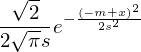

In [2]:
x,F,m,s,k,n = sym.symbols("x F m s k n")
G = 1/(s*sym.sqrt(2*sym.pi)) * sym.exp(-(x-m)**2/(2*s**2))
G

In [3]:
G.evalf(subs={x: 0, m: 0, s: 1})

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

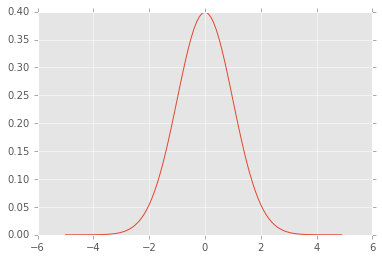

In [5]:
qq = [G.evalf(subs={x: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

In [6]:
H = sym.fourier_transform(G, x, k)
H

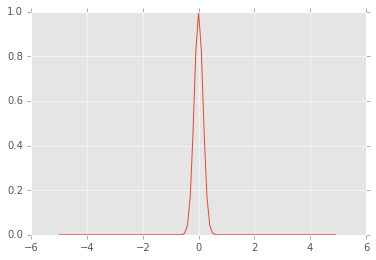

In [7]:
qq = [H.evalf(subs={k: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

Numerical try, see:

http://www.leadnovo.com/4444999026.htm

In [8]:
from scipy.fftpack import fft, fftfreq
t = np.linspace(0., 100., 2000)
signal = np.sin(t / 2.)
#plt.plot(t, signal)

In [9]:
npts = len(t)
FFT = fft(signal)
freqs = fftfreq(npts, t[1]-t[0])
#plt.plot(freqs, np.abs(FFT))
#plt.xlim(-3, 3)

In [10]:
from scipy.fftpack import ifft
signal2 = ifft(FFT)
#plt.plot(t, signal2.real)

### Let's take a look at the Lupton(ZOGY) "post-convolution" kernel...

where here we have substituted $\kappa(k)$ with $\phi_1(k)/\phi_2(k)$.

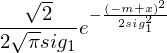

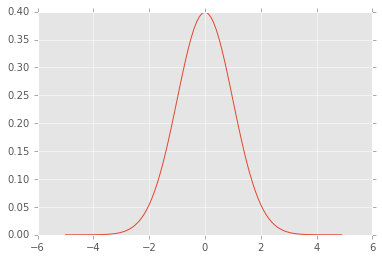

In [11]:
# Define phi1(x) and phi2(x) (the spatial psfs of image 1 and 2) as simple Gaussians (with different sigmas):
sig1, sig2 = sym.symbols("sig1 sig2")

phi = 1/(s*sym.sqrt(2*sym.pi))*sym.exp(-(x-m)**2/(2*s**2))
phi1 = phi.subs(s, sig1)
phi2 = phi.subs(s, sig2)
qq = [phi1.evalf(subs={x: xx, m: 0, sig1: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
phi1

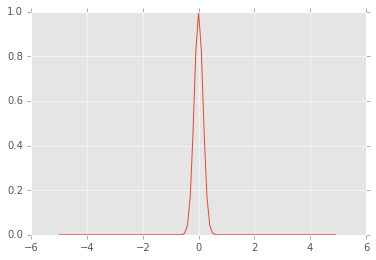

In [12]:
# Now define kappa_ft(k) (the FT of the matching kernel kappa):
phi1_ft = sym.fourier_transform(phi1, x, k)
phi2_ft = sym.fourier_transform(phi2, x, k)
qq = [phi1_ft.evalf(subs={k: xx, m: 0, sig1: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
phi1_ft

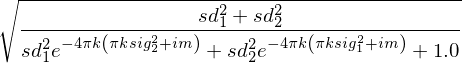

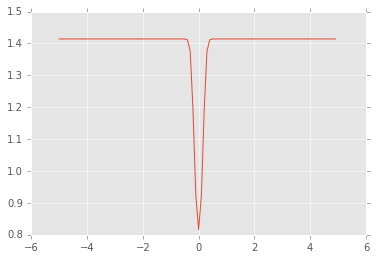

In [25]:
# Use sd1, sd2 for the sigma_1 and sigma_2 (yes, it's confusing!)
# This is unstable (zero denominator) for small values of phi, so we add one to help out.
sd1, sd2 = sym.symbols("sd1 sd2")
post_conv_kernel_ft = sym.sqrt((sd1**2 + sd2**2) / (1. + sd1**2 * phi2_ft**2 + sd2**2 * phi1_ft**2))
qq = [post_conv_kernel_ft.evalf(subs={k:xx, m:0, sig1:1, sig2:1, sd1:1, sd2:1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
post_conv_kernel_ft

Reverse FT the values to get the real-space convolution kernel...

In [15]:
# This takes a long time so let's look at it numerically instead...
if False:
    post_conv_kernel = sym.inverse_fourier_transform(post_conv_kernel_ft, k, x, noconds=False)
    post_conv_kernel

Try it numerically.

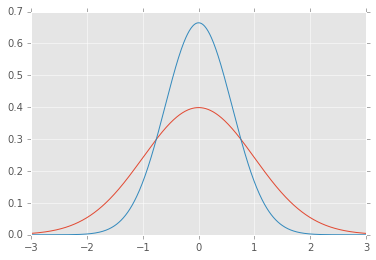

In [35]:
def phi(x, m=0., sig=1.0):
    out = 1/(sig*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*sig**2.))
    return out / out.sum() / (x[1] - x[0])

x = np.arange(-6,6,0.01)
plt.plot(x, phi(x, sig=1.0))
plt.plot(x, phi(x, sig=0.6))
plt.xlim(-3, 3)

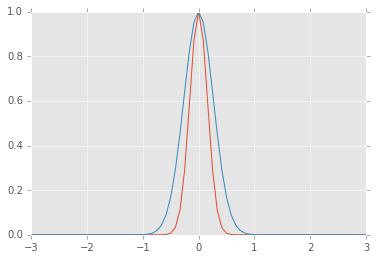

In [36]:
def phi_ft(x, m=0., sig=1.0):
    kp = phi(x, m, sig)
    npts = len(x)
    FFT = fft(kp)
    FFT *= (x[1]-x[0])
    freqs = fftfreq(npts, x[1]-x[0])  # assumes uniformly sampled x!
    return FFT, freqs

FFT1, freqs1 = phi_ft(x, sig=1.0)
FFT2, freqs2 = phi_ft(x, sig=0.6)
plt.plot(np.fft.fftshift(freqs1), np.fft.fftshift(abs(FFT1)))
plt.plot(np.fft.fftshift(freqs2), np.fft.fftshift(abs(FFT2)))
plt.xlim(-3, 3)

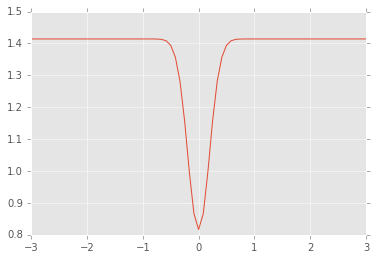

In [40]:
# post_conv_kernel = np.sqrt((sd1**2 + sd2**2) / (sd1**2 * phi2_ft(k)**2 + sd2**2 * phi1_ft(k)**2))
def post_conv_kernel_ft(x, sd1=1., sd2=1., sig1=1., sig2=1., m=0., offset=1.):
    phi1_ft, freqs = phi_ft(x, m, sig1)
    phi2_ft, freqs = phi_ft(x, m, sig2)
    return np.sqrt((sd1**2 + sd2**2) / (sd1**2 * phi2_ft**2 + sd2**2 * phi1_ft**2 + offset)), freqs

kft, freqs = post_conv_kernel_ft(x, sig1=1., sig2=0.6)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(kft.real))
plt.xlim(-3, 3)

-0.00289724049653
-0.00289703065945
0.816496580928


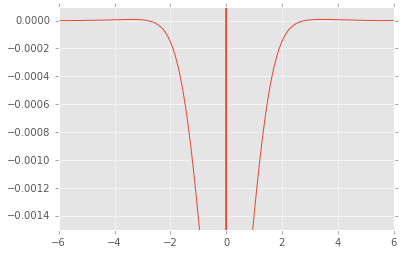

In [44]:
def post_conv_kernel(x, sd1=1., sd2=1., sig1=1., sig2=1., m=0., offset=1.):
    kft, freqs = post_conv_kernel_ft(x, sd1, sd2, sig1, sig2, m, offset)
    out = ifft(kft)
    return out

pck = post_conv_kernel(x,  sig1=1., sig2=0.6)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.0015, 0.0001)

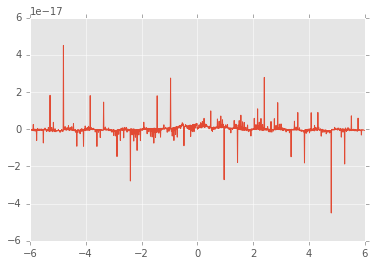

In [46]:
# Ensure there is no trend in the imag. component:
plt.plot(x, np.fft.ifftshift(pck.imag))

Let's look at it for given limits.

1. case 1 (Cell #18): $\sigma_1 = \sigma_2$ and $\kappa$ is a gaussian with $\sigma=1$ (note that $\kappa$ in this case is the matching kernel between the "pre-convolved" $I_1$ and the "template" $I_2$). In this case, the "post-convolution" kernel is a $\delta$-function with amplitude equal to $\sqrt(2)$. 
2. case 2 (Cell #20): $\sigma_2 = 0$ (i.e. a template with no noise). As expected, the "post-convolution" kernel is a $\delta$-function with amplitude equal to $1$. (See Cell #25).
3. case 3 (Cell #21): deconvolution where $\kappa$ is narrower than one. This increases the width of $\kappa$ in $k$ space and thus decreases the amplitude of the $\delta$-function in real-space (and adds ringing/width).
4. case 4 (Cell #22): case where template $I_2$ is noisier than the image, let's just set $\sigma_1 = 0.1$. The result is still a $\delta$-function but with amplitude $1/\sigma_1$ - so we re-scale the variance by this amount.

-0.414778167969
-0.000564589887246
0.816496580928


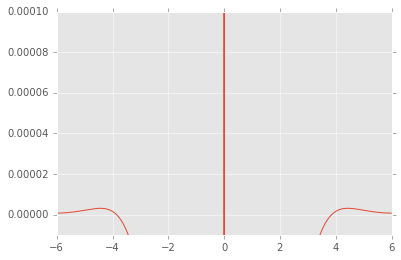

In [48]:
pck = post_conv_kernel(x, sig1=1., sig2=1e-5)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.00001, 0.0001)

-0.00223182313964
-0.00223173951912
0.816496580928


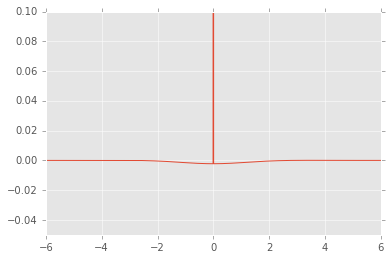

In [49]:
pck = post_conv_kernel(x, sig1=1., sig2=0.9)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.05, 0.1)

-0.0140844503882
-0.0140439496606
0.816496580928


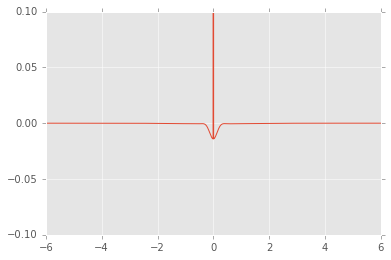

In [50]:
pck = post_conv_kernel(x, sig1=0.1, sig2=1.0)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.1, 0.1)

-0.00317174063065
-0.00458881346217
0.816496580928


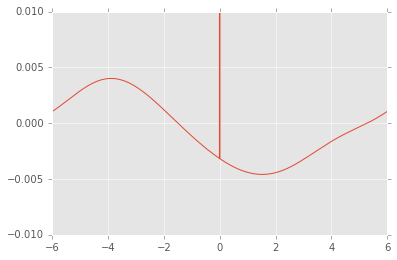

In [51]:
pck = post_conv_kernel(x, m=3.) ## look at offset
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.01, 0.01)

12.6433589176
-0.0845562882675
0.997509336108


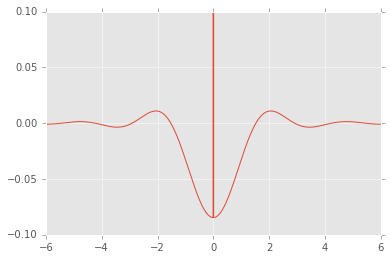

In [54]:
pck = post_conv_kernel(x, sig1=1.0, sig2=1.0, offset=0.01)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.1, 0.1)

Let's look at the PSF of the diffim: $\phi_D$ in $k$ space and real space.